In [1]:
import os
import numpy as np
import xarray as xr
import cftime
import pandas as pd
import glob
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='02:00:00',                                       # Amount of wall time
    interface='ext')

In [3]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.91:46861,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Total threads: 0
Started: 17 minutes ago,Total memory: 0 B


In [6]:
fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE',
              'QVEGT', 'EFLX_LH_TOT', 'FSH', 'FSR', 'FSDS', 'FSA',
              'FIRE', 'FLDS', 'FCTR', 'FCEV', 'FGEV', 'BTRANMN',
              'FGR', 'SOILWATER_10CM', 'TWS', 'QRUNOFF', 'SNOWDP',
              'TV', 'TG', 'TSA', 'TBOT']

clm_vars = ['FPSN', 'TLAI', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH',
            'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FCTR', 'FCEV',
            'FGEV', 'BTRANMN', 'FGR', 'SOILWATER_10CM', 'TWS',
            'QRUNOFF', 'SNOWDP', 'TV', 'TG', 'TSA', 'TBOT']

out_vars = ['GPP', 'LAI', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM', 'ASA',
            'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN', 'TV']

In [7]:
# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea  # km2

# create a global land frac grid
land_frac_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')
land_frac = target_grid.landfrac

In [8]:
ilamb_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')

In [9]:
hist_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse/lnd/hist'
files = sorted(glob.glob(f"{hist_dir}/*clm2.h0*.nc"))
ds = analysis.get_clm_ds(files, fates_vars, 2000)

In [10]:
ds['biome'] = whittaker_ds.biome
ds['biome_name'] = whittaker_ds.biome_name

ds = ds.sel(time=slice('2040-01-01', '2059-12-31'))
ds["time"] = xr.cftime_range(str(2000), periods=len(ds.time), freq="MS")
ds = ds.sel(time=slice('2000-01-01', '2014-12-31'))

In [22]:
months = ds["time.daysinmonth"]
monthly_sum = 60*24*60*(months * ds.GPP).groupby("time.month").mean()
monthly_global = analysis.area_mean_from_sparse(monthly_sum, ds.biome, 'global', 1e-6, land_area)

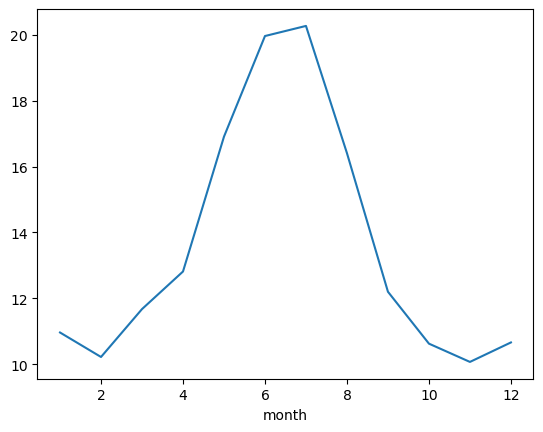

In [24]:
monthly_global.plot()

In [26]:
month_of_max = monthly_sum.idxmax(dim='month')
months = analysis.global_from_sparse(sparse_grid, month_of_max, ds)

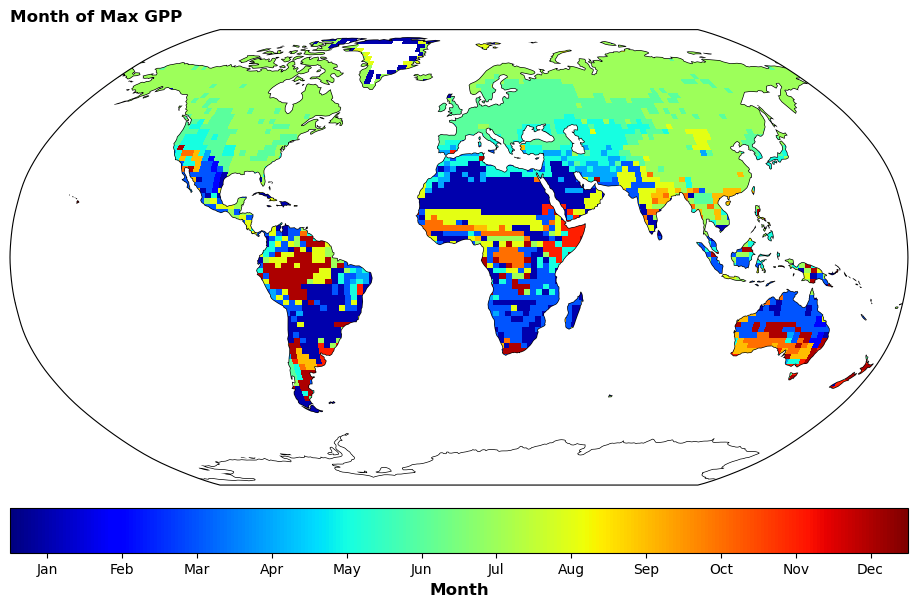

In [27]:
figure, axes = plotting.generate_subplots(1)
pcm = plotting.map_function(axes[0], months, 'Month of Max GPP', 'jet', 12.5, 0.5)
cbar = figure.colorbar(pcm, ax=axes[0], fraction=0.5, orientation='horizontal')
cbar.set_label('Month', size=12, fontweight='bold')
cbar.set_ticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
                     'Sep', 'Oct', 'Nov', 'Dec'])

In [ ]:
annual_means = analysis.get_annual_means(ds, out_vars, var_dict, sparse=True)

In [ ]:
global_area_means = analysis.get_sparse_area_means(annual_means, 'global',
                                                   out_vars, var_dict, land_area,
                                                   ds.biome)

In [ ]:
global_ds = analysis.get_sparse_maps(annual_means, sparse_grid, land_frac, out_vars)

In [ ]:
def plot_global_ilamb_comparison(ilamb_obs, global_ds):
    

In [ ]:
ilamb_da = ilamb.get_model_da(ilamb_obs, ilambvar, ['FLUXCOM', 'WECANN', 'GBAF'])
fates_da = global_ds[var].mean(dim='year').to_dataset(name=var)

In [ ]:
models = ilamb_da.model.values
figure, axes = plotting.generate_subplots(len(models)+1)
axes = axes.flatten(order="F")
for idx, ax in enumerate(axes):
    if idx < 3:
        obs_gpp = ilamb_da.sel(model=models[idx])
        fates_diff = fates_da.GPP - obs_gpp
        title = f"FATES - {models[idx]}"
    else:
        fates_diff = fates_da.GPP - ilamb_da.mean(dim='model')
        title = f"FATES - {len(models)}-model average"
    
    pcm = plotting.map_function(ax, fates_diff, title, 'RdBu_r', 2.5, -2.5, diverging_cmap=True)
cbar = figure.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.5, orientation="horizontal")
cbar.set_label(f"GPP Difference (kgC m-2 yr-1)", size=10, fontweight="bold")